In [1]:
# ============================================
# SOLARINDS Feature Engineering with Volatility Regimes
# ============================================

import yfinance as yf
import pandas as pd
import numpy as np

# --------------------------------------------
# 1. Download SOLARINDS stock data
# --------------------------------------------
ticker = "SOLARINDS.NS"
data = yf.download(ticker, start="2015-01-01", end="2025-10-01")

# Flatten MultiIndex columns (for consistency)
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns.values]

# --------------------------------------------
# 2. Daily percentage returns
# --------------------------------------------
data['Return'] = data['Close_SOLARINDS.NS'].pct_change() * 100

# --------------------------------------------
# 3. Lag features (1 to 5 days)
# --------------------------------------------
for lag in range(1, 6):
    data[f'Lag{lag}'] = data['Return'].shift(lag)

# --------------------------------------------
# 4. Volume (in billions)
# --------------------------------------------
data['Volume'] = data['Volume_SOLARINDS.NS'] / 1e9

# --------------------------------------------
# 5. RSI (14-day) and 3-day average RSI
# --------------------------------------------
window_length = 14
delta = data['Close_SOLARINDS.NS'].diff()

gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=window_length, min_periods=window_length).mean()
avg_loss = loss.rolling(window=window_length, min_periods=window_length).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
data['RSI'] = rsi
data['RSI_Avg3'] = data['RSI'].rolling(window=3).mean()

# --------------------------------------------
# 6. EMA features (20-day)
# --------------------------------------------
ema_period = 20
data['EMA'] = data['Close_SOLARINDS.NS'].ewm(span=ema_period, adjust=False).mean()
data['EMA_Compare'] = np.where(data['Close_SOLARINDS.NS'] > data['EMA'], 'Above EMA', 'Below EMA')
data['EMA_Diff_Pct'] = ((data['Close_SOLARINDS.NS'] - data['EMA']) / data['EMA']) * 100

# --------------------------------------------
# 7. Weighted lag average (decaying weights)
# --------------------------------------------
weights = np.array([0.5**(i-1) for i in range(1, 6)])
weights = weights / weights.sum()
lag_cols = [f'Lag{i}' for i in range(1, 6)]
data['Lag_Weighted_Avg'] = data[lag_cols].mul(weights, axis=1).sum(axis=1)

# --------------------------------------------
# 8. Today's return and Direction classification
# --------------------------------------------
data['Today'] = data['Return']

def classify_direction(x, up_thresh=1, down_thresh=-1):
    if x > up_thresh:
        return 'UP'
    elif x < down_thresh:
        return 'DOWN'
    else:
        return 'HOLD'

data['Direction'] = data['Today'].apply(classify_direction)

# --------------------------------------------
# 9. Add Year
# --------------------------------------------
data['Year'] = data.index.year

# --------------------------------------------
# 10. Add India VIX and define volatility regimes
# --------------------------------------------
vix = yf.download("^INDIAVIX", start="2010-01-01", end="2025-10-31")['Open']
vix.name = '^INDIAVIX'

data = data.merge(vix, left_index=True, right_index=True, how='left')

low_thresh = data['^INDIAVIX'].quantile(0.30)
high_thresh = data['^INDIAVIX'].quantile(0.70)

def classify_volatility(v):
    if v < low_thresh:
        return 'Low'
    elif v > high_thresh:
        return 'High'
    else:
        return 'Medium'

data['Volatility_Regime'] = data['^INDIAVIX'].apply(classify_volatility)

# --------------------------------------------
# 11. Final feature selection (remove Return, Today as features)
# --------------------------------------------
final_cols = [
    'Close_SOLARINDS.NS',
    'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5',
    'Lag_Weighted_Avg',
    'Volume',
    'RSI', 'RSI_Avg3',
    'EMA', 'EMA_Compare', 'EMA_Diff_Pct',
    'Year',
    '^INDIAVIX',
    'Volatility_Regime',
    'Direction'  # keep as target/label
]

# --------------------------------------------
# 12. Split into Volatility Regime DataFrames
# --------------------------------------------
final_df = data[final_cols].dropna().reset_index(drop=True)
low_vol_df = final_df[final_df['Volatility_Regime'] == 'Low'].reset_index(drop=True)
med_vol_df = final_df[final_df['Volatility_Regime'] == 'Medium'].reset_index(drop=True)
high_vol_df = final_df[final_df['Volatility_Regime'] == 'High'].reset_index(drop=True)

# --------------------------------------------
# 13. Save and summarize
# --------------------------------------------
final_df.to_csv("SOLARINDS_Features_with_VIX.csv", index=False)
low_vol_df.to_csv("SOLARINDS_LowVol.csv", index=False)
med_vol_df.to_csv("SOLARINDS_MedVol.csv", index=False)
high_vol_df.to_csv("SOLARINDS_HighVol.csv", index=False)

print("✅ Feature engineering complete.")
print(f"Low Vol Days: {len(low_vol_df)} | Medium Vol Days: {len(med_vol_df)} | High Vol Days: {len(high_vol_df)}")
print("\nAll regime DataFrames have identical structure with Direction as label.")


/tmp/ipython-input-2119876261.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-10-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2119876261.py:90: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^INDIAVIX", start="2010-01-01", end="2025-10-31")['Open']
[*********************100%***********************]  1 of 1 completed

✅ Feature engineering complete.
Low Vol Days: 791 | Medium Vol Days: 1041 | High Vol Days: 788

All regime DataFrames have identical structure with Direction as label.


In [2]:
# Check the columns of the dataframes to confirm if '^INDIAVIX' exists
print("Low Volatility Columns:", low_vol_df.columns.tolist())
print("Medium Volatility Columns:", med_vol_df.columns.tolist())
print("High Volatility Columns:", high_vol_df.columns.tolist())

# Also confirm size of each regime dataset
print("\nDataset shapes:")
print("Low Volatility:", low_vol_df.shape)
print("Medium Volatility:", med_vol_df.shape)
print("High Volatility:", high_vol_df.shape)

Low Volatility Columns: ['Close_SOLARINDS.NS', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag_Weighted_Avg', 'Volume', 'RSI', 'RSI_Avg3', 'EMA', 'EMA_Compare', 'EMA_Diff_Pct', 'Year', '^INDIAVIX', 'Volatility_Regime', 'Direction']
Medium Volatility Columns: ['Close_SOLARINDS.NS', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag_Weighted_Avg', 'Volume', 'RSI', 'RSI_Avg3', 'EMA', 'EMA_Compare', 'EMA_Diff_Pct', 'Year', '^INDIAVIX', 'Volatility_Regime', 'Direction']
High Volatility Columns: ['Close_SOLARINDS.NS', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag_Weighted_Avg', 'Volume', 'RSI', 'RSI_Avg3', 'EMA', 'EMA_Compare', 'EMA_Diff_Pct', 'Year', '^INDIAVIX', 'Volatility_Regime', 'Direction']

Dataset shapes:
Low Volatility: (791, 17)
Medium Volatility: (1041, 17)
High Volatility: (788, 17)


In [3]:
low_vol_df

,Close_SOLARINDS.NS,Lag1,Lag2,Lag3,Lag4,Lag5,Lag_Weighted_Avg,Volume,RSI,RSI_Avg3,EMA,EMA_Compare,EMA_Diff_Pct,Year,^INDIAVIX,Volatility_Regime,Direction
0,633.442444,-1.463426,1.169583,-3.376785,-2.449758,-1.123175,-1.083483,0.000004,55.978738,52.987988,630.940075,Above EMA,0.396610,2015,13.67,Low,UP
1,625.737976,2.585453,-1.463426,1.169583,-3.376785,-2.449758,0.810802,0.000153,50.393107,51.954376,630.444637,Below EMA,-0.746562,2015,13.14,Low,DOWN
2,660.762146,0.039695,0.974855,3.842848,-0.612548,-1.216285,0.689160,0.000011,55.202198,53.121793,637.446926,Above EMA,3.657594,2015,13.67,Low,UP
3,655.668823,0.284334,0.096894,0.385990,-1.095751,3.992129,0.279648,0.000018,74.063678,62.097715,632.035297,Above EMA,3.739273,2015,13.65,Low,UP
4,657.248718,2.645277,0.284334,0.096894,0.385990,-1.095751,1.440739,0.000007,73.866569,69.776124,634.436576,Above EMA,3.595654,2015,13.75,Low,HOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,14022.000000,-1.721515,-1.417666,0.376274,-1.369771,1.444315,-1.247603,0.000079,49.130230,52.498474,14360.234436,Below EMA,-2.355355,2025,10.63,Low,DOWN
787,14148.000000,-1.357721,-1.721515,-1.417666,0.376274,-1.369771,-1.347856,0.000083,55.523945,50.951761,14340.021632,Below EMA,-1.339061,2025,10.52,Low,HOLD
788,13766.000000,0.898588,-1.357721,-1.721515,-1.417666,0.376274,-0.188048,0.000120,46.580332,50.411502,14285.352905,Below EMA,-3.635562,2025,10.78,Low,DOWN
789,13545.000000,-2.700028,0.898588,-1.357721,-1.721515,-1.417666,-1.493656,0.000710,43.615006,48.573094,14214.843105,Below EMA,-4.712279,2025,11.43,Low,DOWN


In [4]:
print("\n=== Direction Class Distribution ===")
print(low_vol_df['Direction'].value_counts())

# If you also want percentages:
print("\n=== Direction Class Distribution (Percentages) ===")
print(low_vol_df['Direction'].value_counts(normalize=True) * 100)


=== Direction Class Distribution ===
Direction
HOLD    445
UP      184
DOWN    162
Name: count, dtype: int64

=== Direction Class Distribution (Percentages) ===
Direction
HOLD    56.257901
UP      23.261694
DOWN    20.480405
Name: proportion, dtype: float64


In [5]:
print("\n=== Direction Class Distribution ===")
print(med_vol_df['Direction'].value_counts())

# If you also want percentages:
print("\n=== Direction Class Distribution (Percentages) ===")
print(med_vol_df['Direction'].value_counts(normalize=True) * 100)


=== Direction Class Distribution ===
Direction
HOLD    547
DOWN    250
UP      244
Name: count, dtype: int64

=== Direction Class Distribution (Percentages) ===
Direction
HOLD    52.545629
DOWN    24.015370
UP      23.439001
Name: proportion, dtype: float64


In [6]:
print("\n=== Direction Class Distribution ===")
print(high_vol_df['Direction'].value_counts())

# If you also want percentages:
print("\n=== Direction Class Distribution (Percentages) ===")
print(high_vol_df['Direction'].value_counts(normalize=True) * 100)


=== Direction Class Distribution ===
Direction
HOLD    409
UP      192
DOWN    187
Name: count, dtype: int64

=== Direction Class Distribution (Percentages) ===
Direction
HOLD    51.903553
UP      24.365482
DOWN    23.730964
Name: proportion, dtype: float64


In [7]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

sns.set(style="whitegrid", palette="deep", context="talk")

# Assuming these three DataFrames are already created:
# low_vol_df, med_vol_df, high_vol_df

datasets = {
    "Low Volatility": low_vol_df,
    "Medium Volatility": med_vol_df,
    "High Volatility": high_vol_df
}

numeric_cols = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'RSI_Avg3', 'Today']
categorical_cols = ['EMA_Compare', 'Direction']

# Combine for global-level EDA plots
all_dirs = pd.concat([df.assign(Regime=k) for k, df in datasets.items()])


In [8]:
# Robust summary per regime — avoids missing-column errors
for regime, df in datasets.items():
    print(f"\n===== {regime} Regime =====")
    print(f"Shape: {df.shape}")

    # Direction counts (safe)
    if 'Direction' in df.columns:
        print("\nDirection Counts:\n", df['Direction'].value_counts())
    else:
        print("\nDirection column not found in this DataFrame.")

    # EMA_Compare counts (safe)
    if 'EMA_Compare' in df.columns:
        print("\nEMA Compare Counts:\n", df['EMA_Compare'].value_counts())
    else:
        print("\nEMA_Compare column not found in this DataFrame.")

    # Only describe numeric columns that actually exist in the DataFrame
    # define the expected numeric columns list (adapted to what you kept)
    expected_numeric = ['Lag1','Lag2','Lag3','Lag4','Lag5','Volume','RSI_Avg3','Today','Return','Lag_Weighted_Avg','EMA_Diff_Pct']
    present_numeric = [c for c in expected_numeric if c in df.columns]

    if present_numeric:
        print("\nDescriptive Stats:\n", df[present_numeric].describe().round(2))
    else:
        print("\nNo expected numeric columns found to describe.")




===== Low Volatility Regime =====
Shape: (791, 17)

Direction Counts:
 Direction
HOLD    445
UP      184
DOWN    162
Name: count, dtype: int64

EMA Compare Counts:
 EMA_Compare
Above EMA    556
Below EMA    235
Name: count, dtype: int64

Descriptive Stats:
          Lag1    Lag2    Lag3    Lag4    Lag5  Volume  RSI_Avg3  \
count  791.00  791.00  791.00  791.00  791.00   791.0    791.00   
mean     0.29    0.23    0.24    0.21    0.19     0.0     56.35   
std      1.82    1.85    1.78    1.81    1.82     0.0     17.05   
min     -5.87   -6.98   -5.87   -6.98   -6.44     0.0      7.45   
25%     -0.71   -0.75   -0.75   -0.77   -0.79     0.0     45.13   
50%      0.09    0.10    0.10    0.05    0.05     0.0     56.37   
75%      0.96    0.91    0.93    0.88    0.89     0.0     68.54   
max     10.87   10.87    9.12    9.12   10.87     0.0     96.37   

       Lag_Weighted_Avg  EMA_Diff_Pct  
count            791.00        791.00  
mean               0.26          1.86  
std              

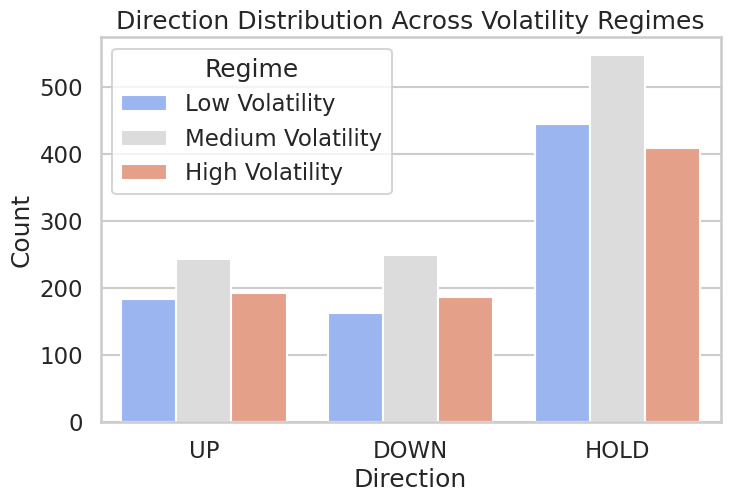

In [9]:


plt.figure(figsize=(8,5))
sns.countplot(data=all_dirs, x='Direction', hue='Regime', palette='coolwarm')
plt.title("Direction Distribution Across Volatility Regimes")
plt.xlabel("Direction")
plt.ylabel("Count")
plt.show()


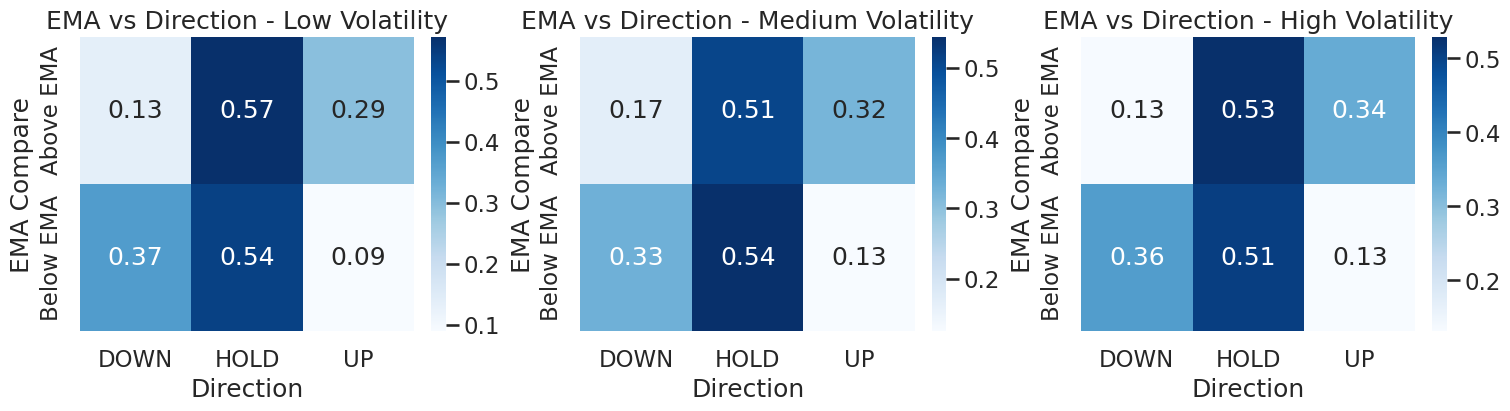

In [10]:


num_regimes = len(datasets)
fig, axes = plt.subplots(1, num_regimes, figsize=(5*num_regimes, 4), constrained_layout=True)

if num_regimes == 1:
    axes = [axes]

for ax, (regime, df) in zip(axes, datasets.items()):
    cross_tab = pd.crosstab(df['EMA_Compare'], df['Direction'], normalize='index')
    sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.2f', ax=ax)
    ax.set_title(f"EMA vs Direction - {regime}")
    ax.set_xlabel("Direction")
    ax.set_ylabel("EMA Compare")

plt.show()


/tmp/ipython-input-2857938462.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Regime")


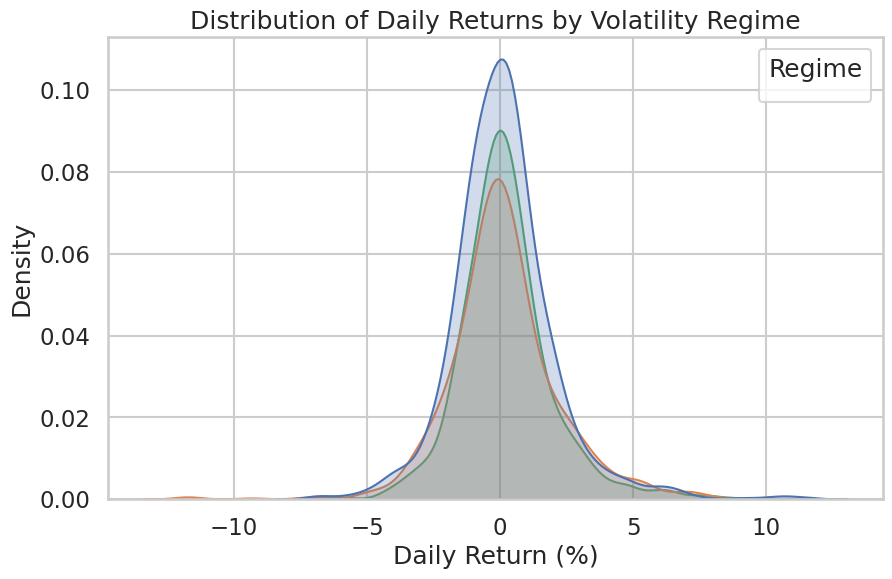

/tmp/ipython-input-2857938462.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


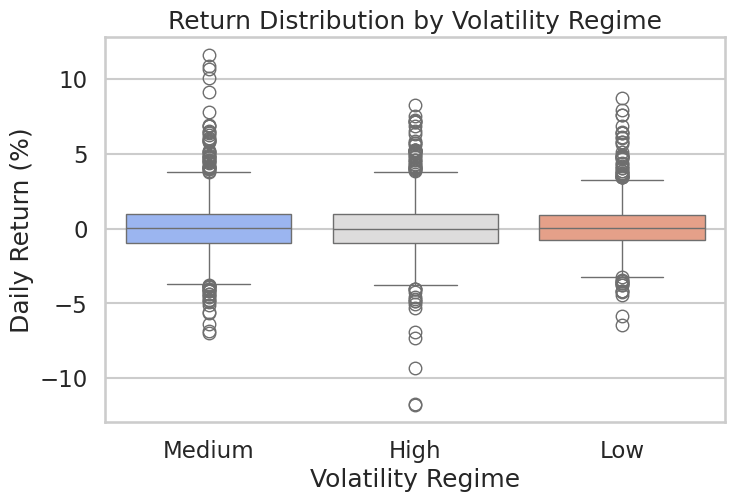

In [11]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.kdeplot(
    data=data, x='Today', hue='Volatility_Regime', fill=True
)
plt.title("Distribution of Daily Returns by Volatility Regime")
plt.xlabel("Daily Return (%)")
plt.legend(title="Regime")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(
    data=data, x='Volatility_Regime', y='Today', palette='coolwarm'
)
plt.title("Return Distribution by Volatility Regime")
plt.xlabel("Volatility Regime")
plt.ylabel("Daily Return (%)")
plt.show()


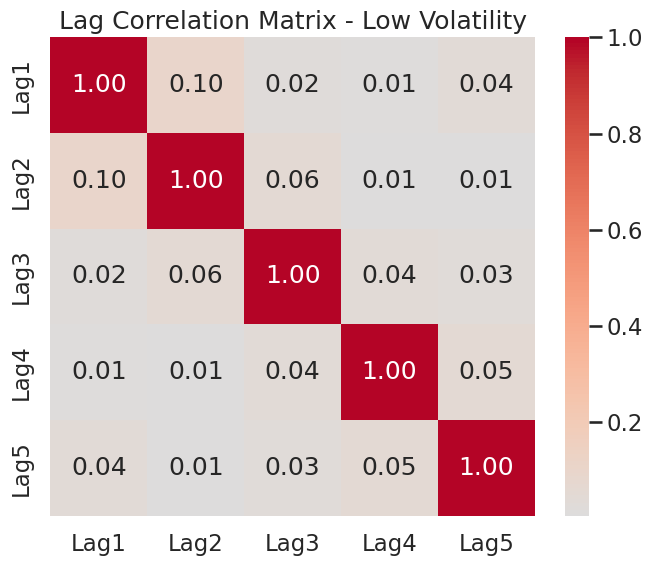

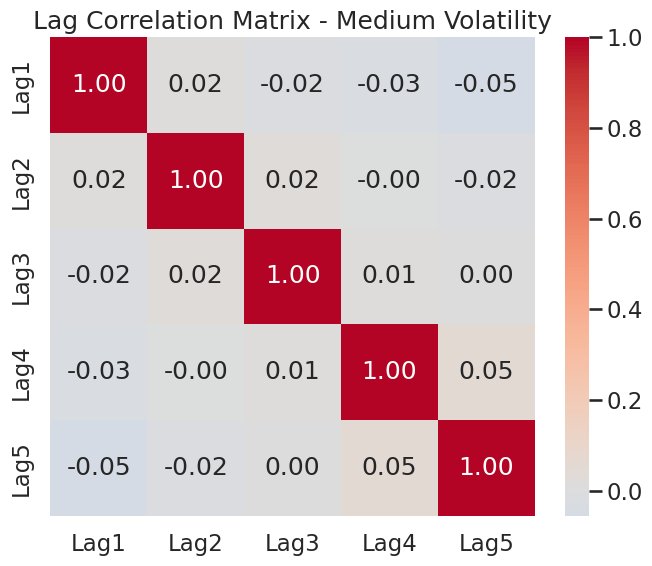

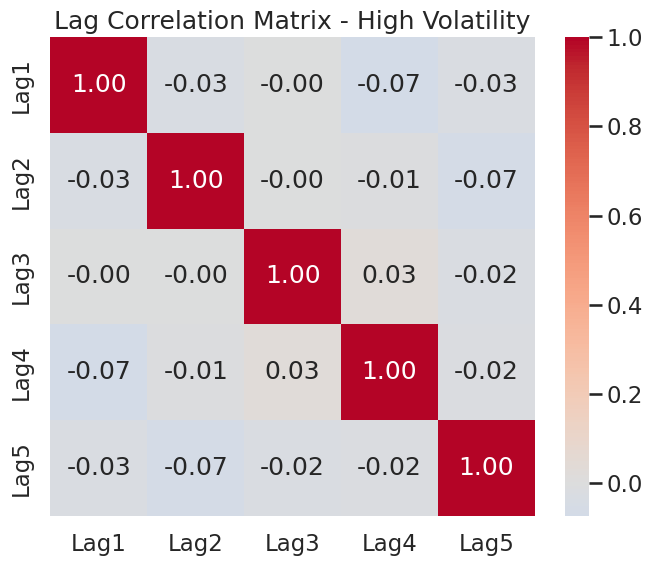

In [12]:


for regime, df in datasets.items():
    plt.figure(figsize=(7,6))
    corr_matrix = df[['Lag1','Lag2','Lag3','Lag4','Lag5']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
    plt.title(f"Lag Correlation Matrix - {regime}")
    plt.tight_layout()
    plt.show()


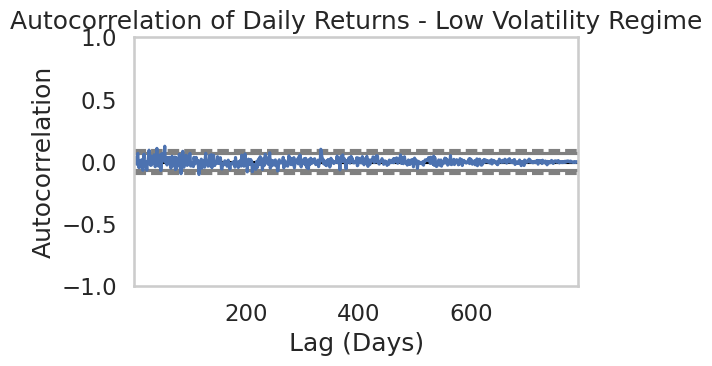

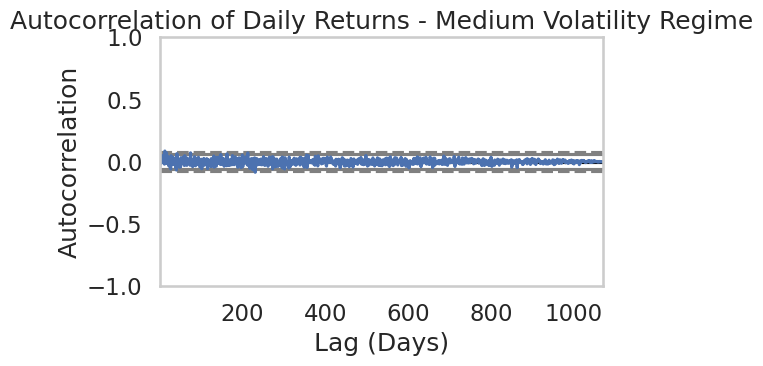

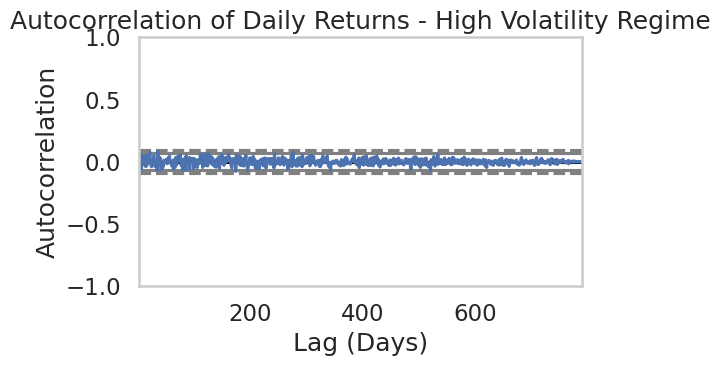

In [13]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# Ensure Today & Volatility_Regime exist in master dataset
assert 'Today' in data.columns and 'Volatility_Regime' in data.columns, \
    "Columns 'Today' and 'Volatility_Regime' must exist in the master dataset."

# Plot autocorrelation of daily returns by volatility regime
for regime in ['Low', 'Medium', 'High']:
    subset = data[data['Volatility_Regime'] == regime].dropna(subset=['Today'])

    plt.figure(figsize=(6,4))
    autocorrelation_plot(subset['Today'])
    plt.title(f"Autocorrelation of Daily Returns - {regime} Volatility Regime")
    plt.xlabel("Lag (Days)")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()


In [14]:


for regime, df in datasets.items():
    lag_corr = df[['Lag1','Lag2','Lag3','Lag4','Lag5']].corr().stack().reset_index()
    lag_corr.columns = ['Feature1','Feature2','Correlation']
    lag_corr = lag_corr[lag_corr['Feature1'] != lag_corr['Feature2']]  # remove diagonal
    print(f"\nTop correlations for {regime} regime:")
    print(lag_corr.sort_values(by='Correlation', ascending=False).head(10))



Top correlations for Low Volatility regime:
   Feature1 Feature2  Correlation
1      Lag1     Lag2     0.098220
5      Lag2     Lag1     0.098220
7      Lag2     Lag3     0.055789
11     Lag3     Lag2     0.055789
23     Lag5     Lag4     0.054727
19     Lag4     Lag5     0.054727
4      Lag1     Lag5     0.039627
20     Lag5     Lag1     0.039627
17     Lag4     Lag3     0.037289
13     Lag3     Lag4     0.037289

Top correlations for Medium Volatility regime:
   Feature1 Feature2  Correlation
19     Lag4     Lag5     0.051911
23     Lag5     Lag4     0.051911
11     Lag3     Lag2     0.022551
7      Lag2     Lag3     0.022551
5      Lag2     Lag1     0.016273
1      Lag1     Lag2     0.016273
13     Lag3     Lag4     0.013830
17     Lag4     Lag3     0.013830
22     Lag5     Lag3     0.003741
14     Lag3     Lag5     0.003741

Top correlations for High Volatility regime:
   Feature1 Feature2  Correlation
17     Lag4     Lag3     0.029730
13     Lag3     Lag4     0.029730
2      Lag1

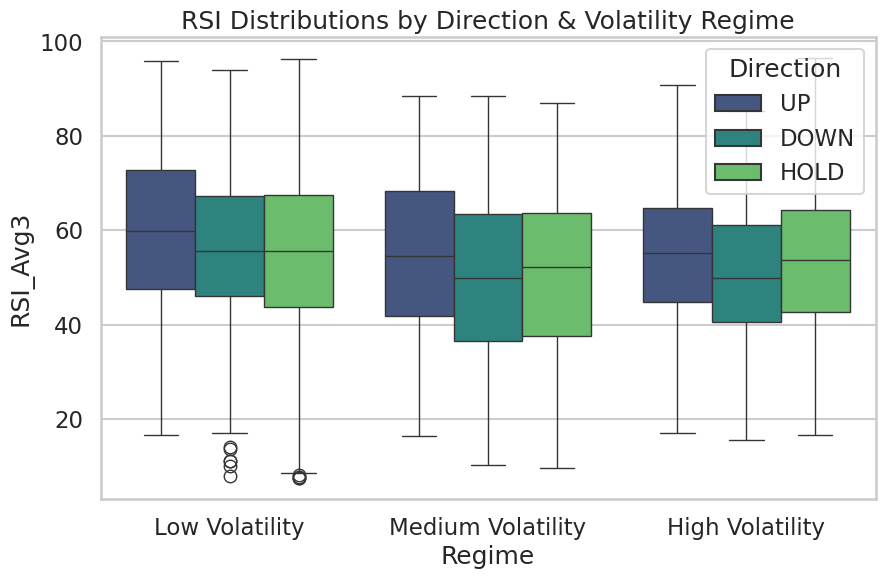

/tmp/ipython-input-2703568823.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_dirs, x='Regime', y='Volume', inner='quartile', palette='cool')


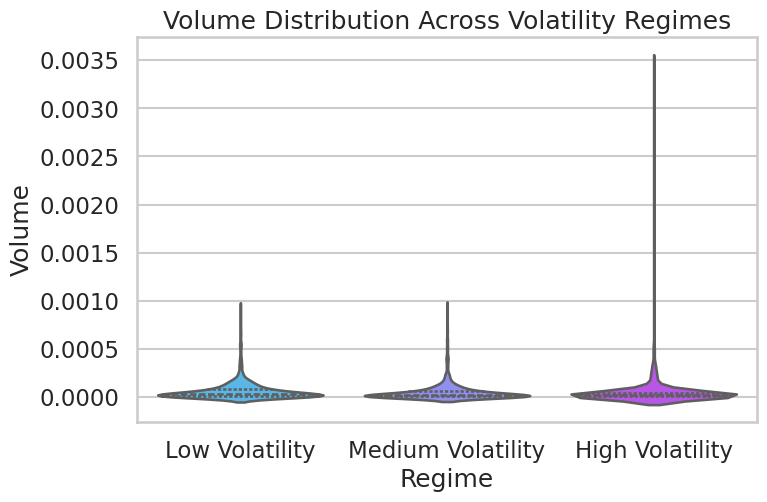

In [15]:


plt.figure(figsize=(10,6))
sns.boxplot(data=all_dirs, x='Regime', y='RSI_Avg3', hue='Direction', palette='viridis')
plt.title("RSI Distributions by Direction & Volatility Regime")
plt.show()

plt.figure(figsize=(8,5))
sns.violinplot(data=all_dirs, x='Regime', y='Volume', inner='quartile', palette='cool')
plt.title("Volume Distribution Across Volatility Regimes")
plt.show()


#EDA

In [16]:
final_df.head()

,Close_SOLARINDS.NS,Lag1,Lag2,Lag3,Lag4,Lag5,Lag_Weighted_Avg,Volume,RSI,RSI_Avg3,EMA,EMA_Compare,EMA_Diff_Pct,Year,^INDIAVIX,Volatility_Regime,Direction
0,592.295044,-1.252992,0.301620,0.035700,2.533247,1.434127,-0.354564,0.000016,77.124076,79.633479,562.684473,Above EMA,5.262376,2015,18.570000,High,UP
1,590.829102,1.201772,-1.252992,0.301620,0.035700,2.533247,0.419856,0.000008,83.785055,79.642834,565.364914,Above EMA,4.504027,2015,17.889999,High,HOLD
2,592.160889,-0.247502,1.201772,-1.252992,0.301620,0.035700,0.041326,0.000016,82.471167,81.126766,567.916911,Above EMA,4.268930,2015,18.090000,High,HOLD
3,593.569580,0.225410,-0.247502,1.201772,-1.252992,0.301620,0.136428,0.000008,77.979609,81.411944,570.360022,Above EMA,4.069282,2015,19.770000,High,HOLD
4,594.221069,0.237890,0.225410,-0.247502,1.201772,-1.252992,0.186131,0.000022,75.114146,78.521641,572.632503,Above EMA,3.770056,2015,19.430000,High,HOLD


In [17]:
final_df.info()
final_df.describe()
final_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close_SOLARINDS.NS  2620 non-null   float64
 1   Lag1                2620 non-null   float64
 2   Lag2                2620 non-null   float64
 3   Lag3                2620 non-null   float64
 4   Lag4                2620 non-null   float64
 5   Lag5                2620 non-null   float64
 6   Lag_Weighted_Avg    2620 non-null   float64
 7   Volume              2620 non-null   float64
 8   RSI                 2620 non-null   float64
 9   RSI_Avg3            2620 non-null   float64
 10  EMA                 2620 non-null   float64
 11  EMA_Compare         2620 non-null   object 
 12  EMA_Diff_Pct        2620 non-null   float64
 13  Year                2620 non-null   int32  
 14  ^INDIAVIX           2620 non-null   float64
 15  Volatility_Regime   2620 non-null   object 
 16  Direct

,0
Close_SOLARINDS.NS,0
Lag1,0
Lag2,0
Lag3,0
Lag4,0
Lag5,0
Lag_Weighted_Avg,0
Volume,0
RSI,0
RSI_Avg3,0


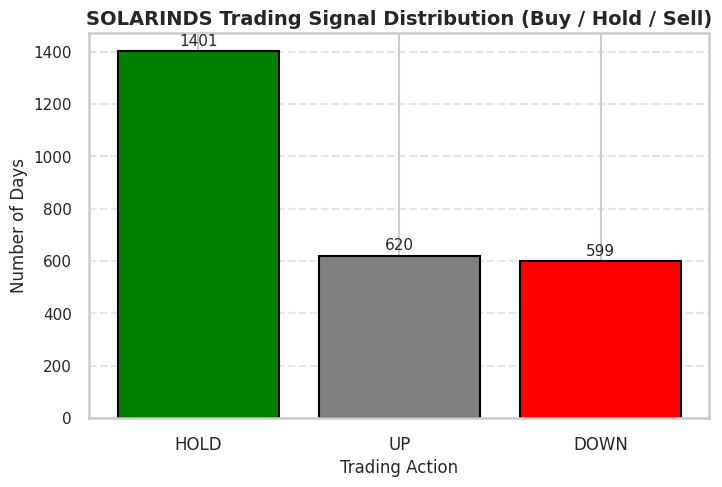

In [18]:

import matplotlib.pyplot as plt

class_counts = final_df['Direction'].value_counts()

plt.figure(figsize=(8,5))
bars = plt.bar(class_counts.index, class_counts.values, color=['green','gray','red'], edgecolor='black')

plt.title("SOLARINDS Trading Signal Distribution (Buy / Hold / Sell)", fontsize=14, fontweight='bold')
plt.xlabel("Trading Action", fontsize=12)
plt.ylabel("Number of Days", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom', fontsize=11)

plt.xticks(fontsize=12)
plt.yticks(fontsize=11)

plt.show()

#This graph shows how frequently each trading action (Buy, Hold, Sell) occurs for SOLARINDS.

In [19]:
pd.crosstab(final_df['Direction'], final_df['Volatility_Regime'])

Volatility_Regime,High,Low,Medium
Direction,,,
DOWN,187,162,250
HOLD,409,445,547
UP,192,184,244


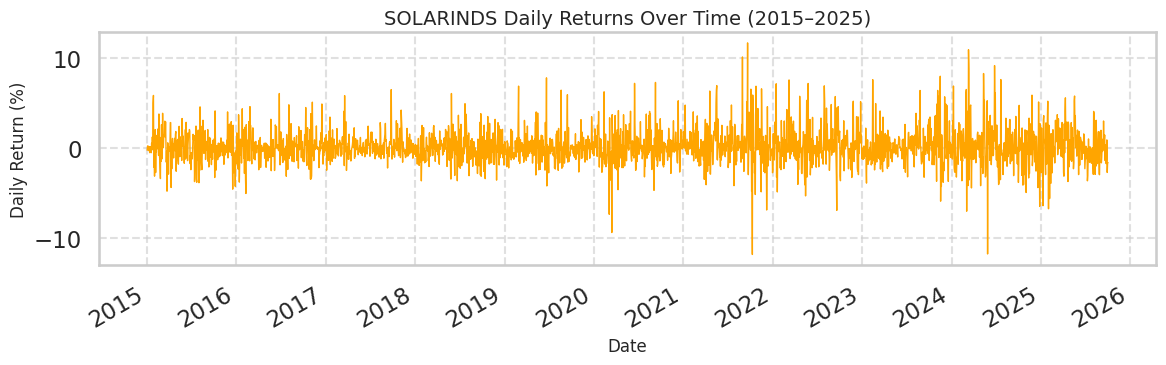

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Create synthetic date range based on final_df length
dates = pd.date_range(start="2015-01-01", end="2025-10-01", periods=len(final_df))

# Compute return from closing price (in final_df)
returns = final_df['Close_SOLARINDS.NS'].pct_change() * 100

# Plot
plt.figure(figsize=(12,4))
plt.plot(dates, returns, color='orange', linewidth=1)

plt.title("SOLARINDS Daily Returns Over Time (2015–2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Return (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


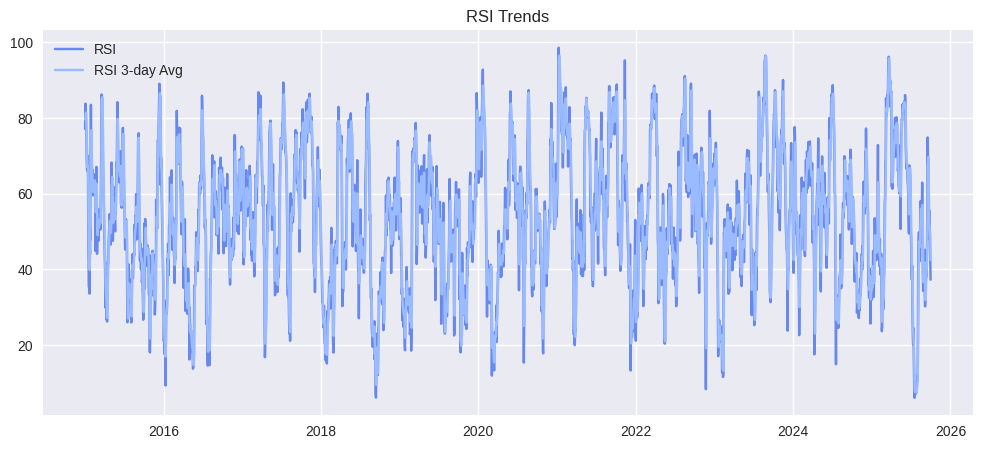

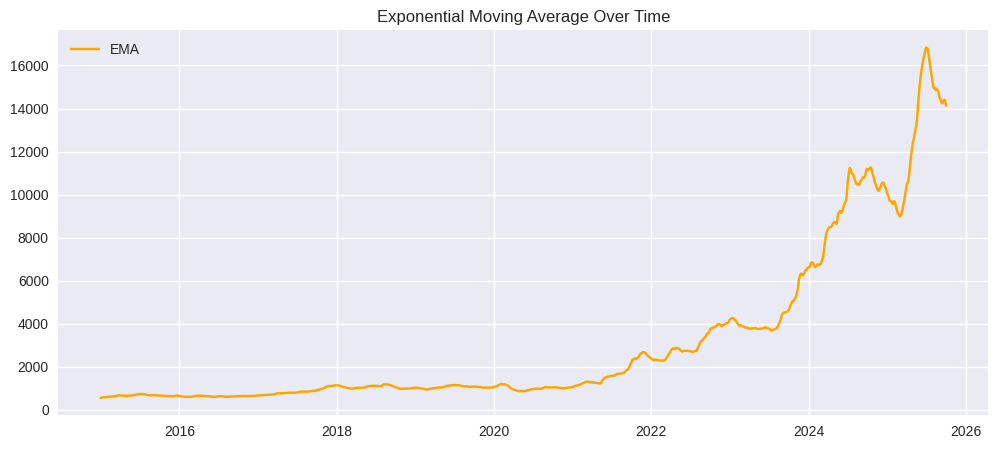

In [21]:
plt.style.use('seaborn-v0_8')
sns.set_palette("coolwarm")

x_axis = pd.date_range(start="2015-01-01", end="2025-10-01", periods=len(final_df))

plt.figure(figsize=(12, 5))
plt.plot(x_axis,final_df['RSI'], label='RSI')
plt.plot(x_axis,final_df['RSI_Avg3'], label='RSI 3-day Avg')
plt.title("RSI Trends")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(x_axis,final_df['EMA'], label='EMA', color='orange')
plt.title("Exponential Moving Average Over Time")
plt.legend()
plt.show()

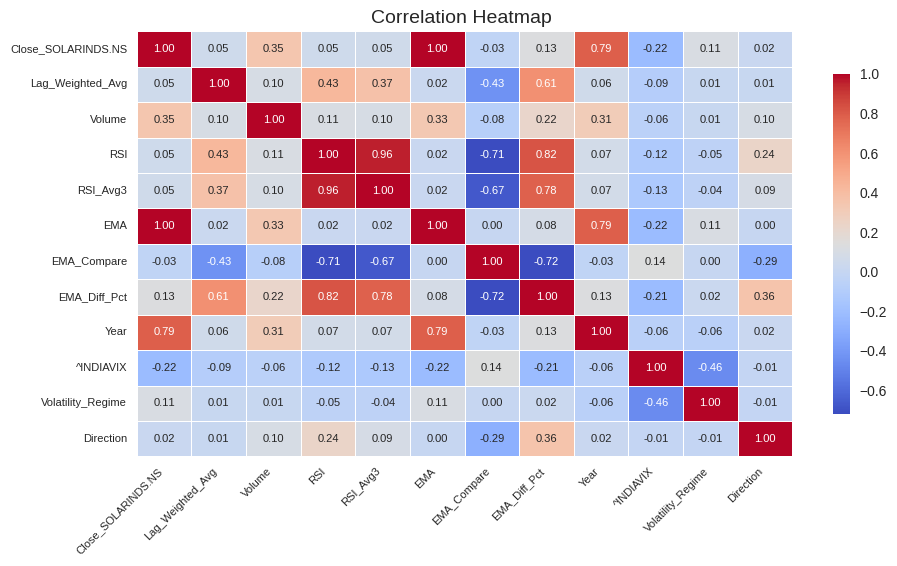

In [22]:
# Correlation Heatmap
numeric_df = final_df.copy()


for col in numeric_df.select_dtypes(include='object').columns:
    numeric_df[col] = numeric_df[col].astype('category').cat.codes

# Dropping the lag columns
numeric_df = numeric_df.drop(columns=['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5'], errors='ignore')


plt.figure(figsize=(10, 6))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap ", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

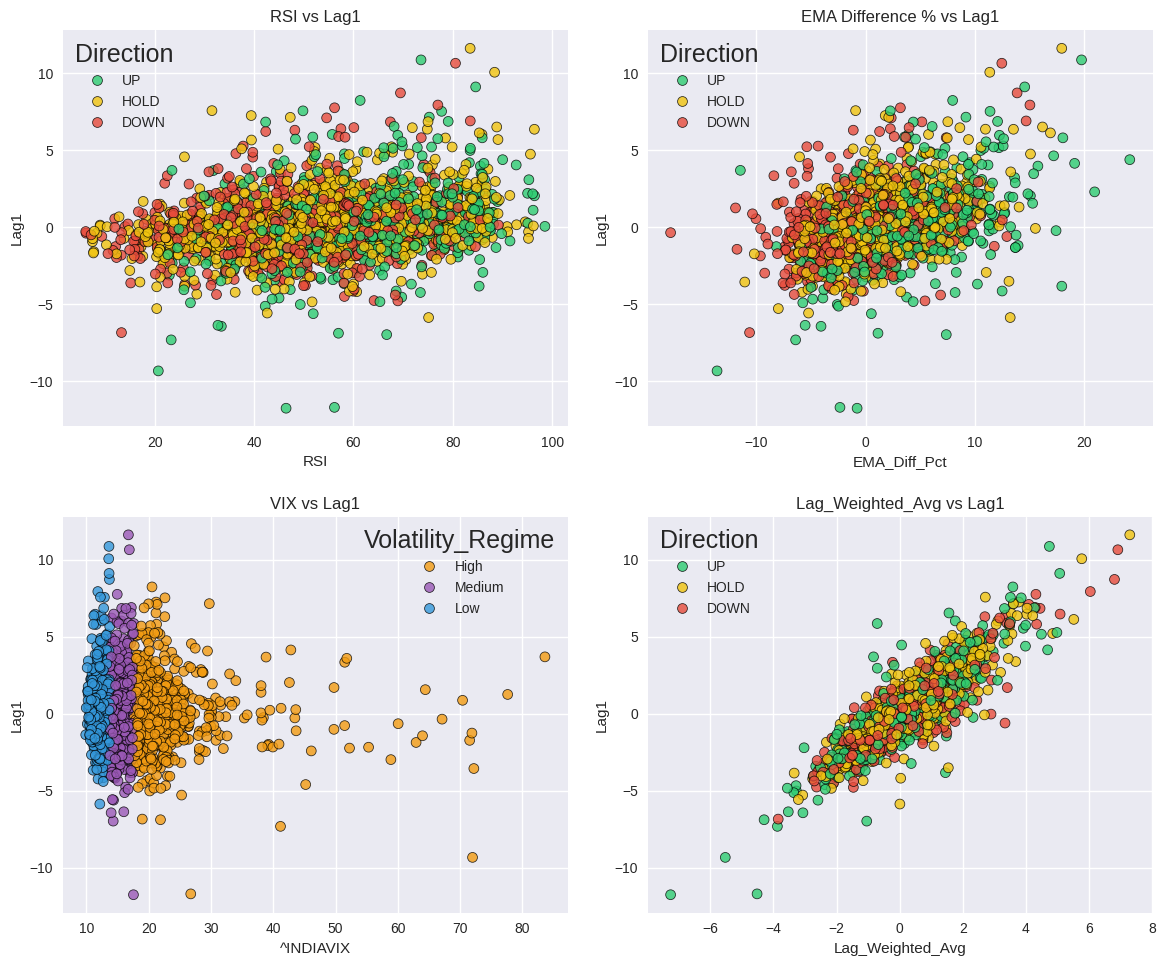

In [24]:



fig, axs = plt.subplots(2, 2, figsize=(12, 10))

direction_palette = {
    'UP': '#2ecc71',
    'DOWN': '#e74c3c',
    'HOLD': '#f1c40f'
}

volatility_palette = {
    'High': '#f39c12',
    'Medium': '#9b59b6',
    'Low': '#3498db',
    'Moderate': '#2ecc71'
}

# Purpose:
# The Relative Strength Index (RSI) measures momentum — whether the stock is overbought (>70) or oversold (<30).
# Plotting RSI against daily Return helps visualize if extreme RSI values correspond to price reversals
# or sustained trends (based on 'Direction' categories UP, DOWN, HOLD).

sns.scatterplot(data=final_df, x='RSI', y='Lag1', hue='Direction',
                palette=direction_palette, ax=axs[0,0], s=50, edgecolor='black', alpha=0.8)
axs[0,0].set_title("RSI vs Lag1")

# Purpose:
# EMA_Diff_Pct shows how far the current price deviates (in %) from the Exponential Moving Average (EMA).
# This helps understand whether being above/below EMA impacts the direction and magnitude of returns.

sns.scatterplot(data=final_df, x='EMA_Diff_Pct', y='Lag1', hue='Direction',
                palette=direction_palette, ax=axs[0,1], s=50, edgecolor='black', alpha=0.8)
axs[0,1].set_title("EMA Difference % vs Lag1")

# Purpose:
# The India VIX index reflects market volatility expectations.
# Plotting VIX against Return (colored by Volatility Regime) highlights how periods of high or low volatility
# influence the stock’s return behavior — typically, higher VIX correlates with larger market swings.

sns.scatterplot(data=final_df, x='^INDIAVIX', y='Lag1', hue='Volatility_Regime',
                palette=volatility_palette, ax=axs[1,0], s=50, edgecolor='black', alpha=0.8)
axs[1,0].set_title("VIX vs Lag1")


# Purpose:
# Lag_Weighted_Avg represents a weighted combination of past returns.
# Plotting it against current Return allows checking whether historical price momentum
# carries predictive power for today’s performance (momentum or mean-reversion behavior).

sns.scatterplot(data=final_df, x='Lag_Weighted_Avg', y='Lag1', hue='Direction',
                palette=direction_palette, ax=axs[1,1], s=50, edgecolor='black', alpha=0.8)
axs[1,1].set_title("Lag_Weighted_Avg vs Lag1")

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'RSI by Direction')

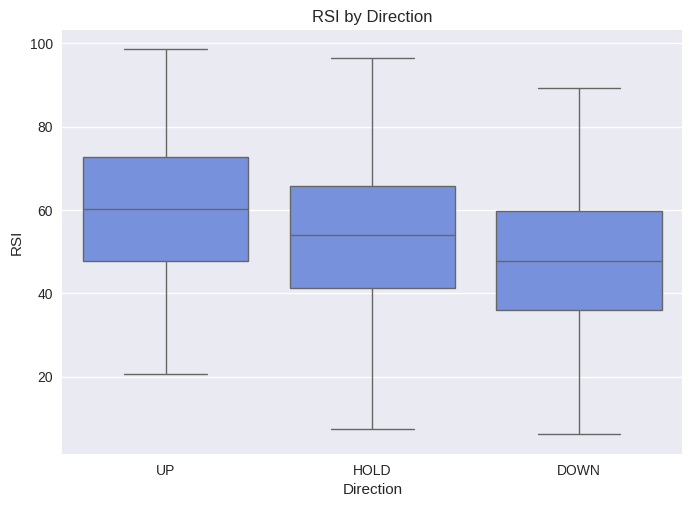

In [25]:
sns.boxplot(x='Direction', y='RSI', data=final_df)
plt.title("RSI by Direction")


Text(0.5, 1.0, 'EMA % Difference by Direction')

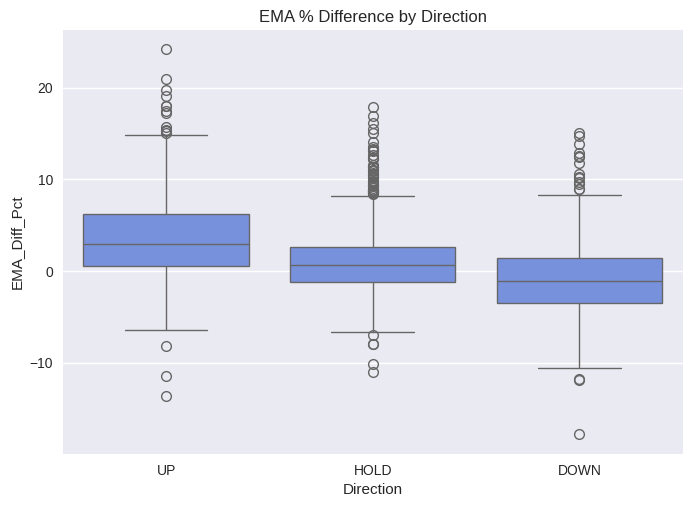

In [26]:
sns.boxplot(x='Direction', y='EMA_Diff_Pct', data=final_df)
plt.title("EMA % Difference by Direction")

<Axes: xlabel='Direction', ylabel='Lag1'>

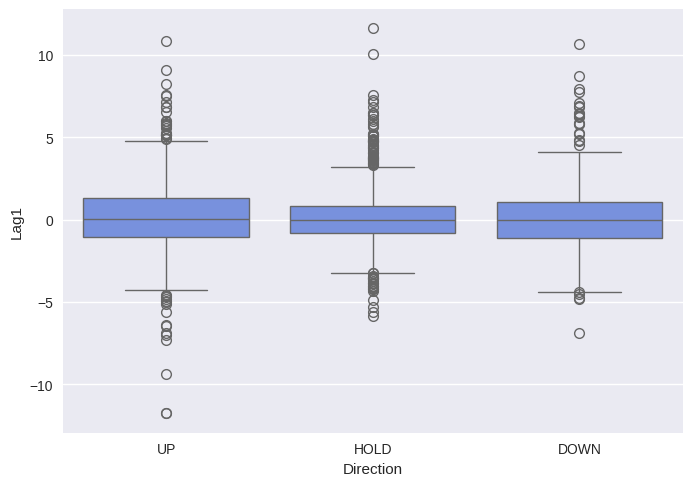

In [27]:
sns.boxplot(x='Direction', y='Lag1', data=final_df)

Text(0.5, 1.0, 'Direction Counts Over Years')

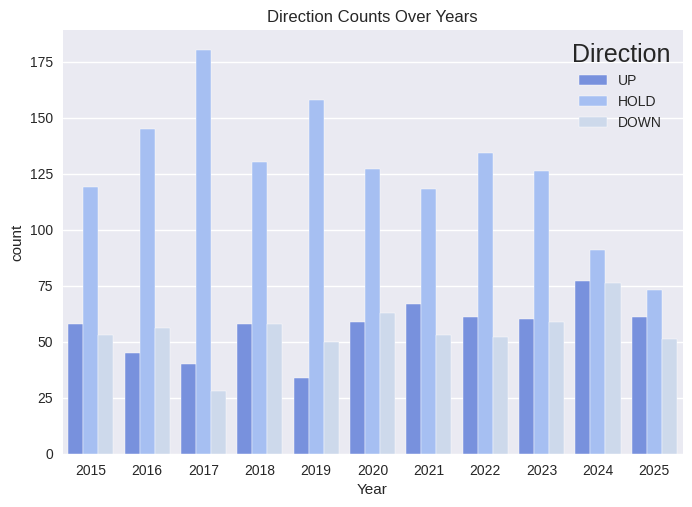

In [29]:
sns.countplot(x='Year', hue='Direction', data=final_df)
plt.title("Direction Counts Over Years")


<Axes: title={'center': 'Feature Importances'}>

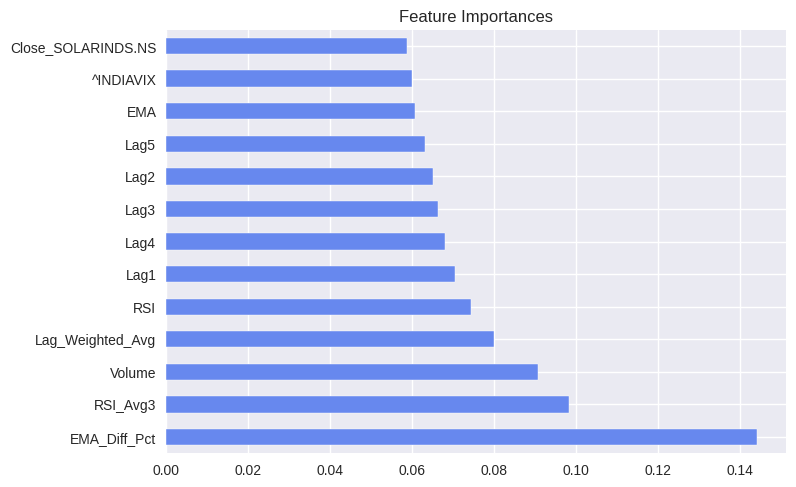

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

df_model = final_df.dropna().copy()
X = df_model.drop(columns=['Direction', 'EMA_Compare', 'Volatility_Regime', 'Year'])
X = pd.get_dummies(X, drop_first=True)
y = LabelEncoder().fit_transform(df_model['Direction'])

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_importances.head(15).plot(kind='barh', title='Feature Importances')

#This identifies which features most strongly influence the prediction of Buy, Hold, or Sell.